
![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# CNN aplicadas a imágenes propias
Para este ejercicio vamos a utilizar una colección de imágenes de Cats and Dogs inspiradas en la clásica <a href='https://www.kaggle.com/c/dogs-vs-cats'>competición de Kaggle</a>.

En el notebook anterior descargamos los archivos, vimos la estructura de directorios, examinamos las imágenes y realizamos diversas transformaciones para preparar el entrenamiento.

En este noebook vamos a definir nuestro modelo, a continuación, alimentar las imágenes a través de una secuencia de entrenamiento y validación utilizando DataLoader.



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Árbol de directorio de los datos
<pre>.
└──IA3_data
    └── CATS_DOGS
        |
        ├── test
        │   ├── CAT
        │   │   ├── 9374.jpg
        │   │   ├── 9375.jpg
        │   │   └── ... (3,126 files)
        │   └── DOG
        │       ├── 9374.jpg
        │       ├── 9375.jpg
        │       └── ... (3,125 files)       
        │           
        └── train
            ├── CAT
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (9,371 files)
            └── DOG
                ├── 0.jpg
                ├── 1.jpg
                └── ... (9,372 files)</pre>

## Importaciones

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Definir transformaciones
Como sabemos, disponemos de  una variedad de transformaciones disponibles para el aumento de datos (rotar, voltear, etc.) y la normalización.<br>
Aquí combinaremos los que queramos, incluyendo los <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>parámetros de normalización recomendados</a> para media y std por canal.

In [3]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Preparar conjuntos de entrenamiento y prueba, cargadores
Vamos a aprovechar una herramienta de conjunto de datos incorporada en torchvision llamada <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'>.<tt><strong>ImageFolder</strong></tt></a>.

In [4]:
#root = '../Data/CATS_DOGS'
root = 'CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 8000
Testing images available:  2000


## Mostrar un lote de imágenes
Para verificar que el cargador de entrenamiento selecciona imágenes de gatos y perros al azar, vamos a mostrar un lote de imágenes cargadas.<br>
Ten en cuenta que imshow recorta valores de píxel <0, por lo que la visualización resultante carece de contraste. Aplicaremos una rápida transformación inversa al tensor de entrada para que las imágenes muestren sus colores "verdaderos".

Label: [1 0 1 0 1 1 0 0 1 1]
Class: DOG CAT DOG CAT DOG DOG CAT CAT DOG DOG


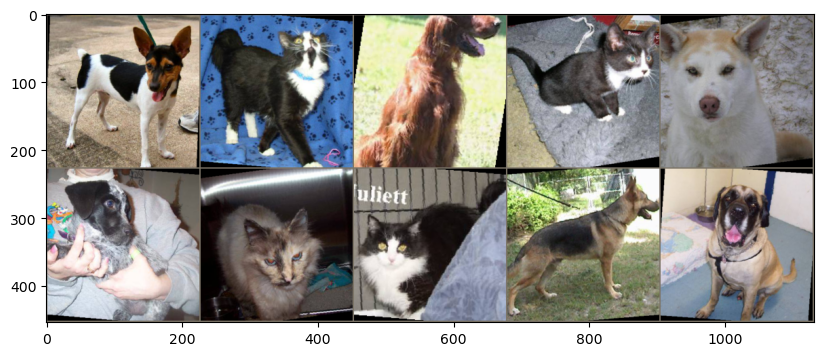

In [5]:
# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Definición del modelo
Empezaremos utilizando un modelo similar al que aplicamos al conjunto de datos CIFAR-10, salvo que aquí tenemos una clasificación binaria (2 canales de salida, no 10). Además, añadiremos otro conjunto de capas de convolución/pooling.

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>Porqué <tt>(54x54x16)</tt>?</strong><br>
Con 224 pixels por cara, los kernels y capas de pooling resultan en $\;(((224-2)/2)-2)/2 = 54.5\;$ que redondeado hacia abajo se queda en 54 píxels por cara.</div>

### Instanciar el modelo, definir las funciones de pérdida y optimización
Vamos a llamar a nuestro modelo "CNNmodel" para diferenciarlo de un "AlexNetmodel" que usaremos más adelante.

In [7]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Parámetros entrenables

In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [9]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


## Entrenamiento el modelo
Este paso consume bastante tiempo y recursos computacionales.
En aras del tiempo, es recomendable limitar el número de lotes de entrenamiento y el número de lotes de prueba.

In [10]:
# usa GPU si disponible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
import time
start_time = time.time()

epochs = 2

max_trn_batch = 800
max_tst_batch = 200

# llevar modelo a GPU
CNNmodel.to(device)

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1

        # push data to GPU
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Data to GPU
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  100 [  1000/8000]  loss: 0.70111519  accuracy:  52.500%
epoch:  0  batch:  200 [  2000/8000]  loss: 0.65032387  accuracy:  56.150%
epoch:  0  batch:  300 [  3000/8000]  loss: 0.62619489  accuracy:  56.933%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.81900185  accuracy:  58.025%
epoch:  0  batch:  500 [  5000/8000]  loss: 0.63294595  accuracy:  59.160%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.71552789  accuracy:  60.333%
epoch:  0  batch:  700 [  7000/8000]  loss: 0.59801954  accuracy:  61.300%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.51543576  accuracy:  62.225%
epoch:  1  batch:  100 [  1000/8000]  loss: 0.47786641  accuracy:  69.200%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.63970041  accuracy:  69.650%
epoch:  1  batch:  300 [  3000/8000]  loss: 0.35752350  accuracy:  69.767%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.64024889  accuracy:  70.350%
epoch:  1  batch:  500 [  5000/8000]  loss: 0.61534083  accuracy:  70.360%
epoch:  1  batch:  600 [ 

## Salvamos el modelo entrenado

In [12]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

## Evaluación de rendimiento del modelo

In [13]:
# Atención! train_losses es una lista de tensores con Autograd activado
train_losses

[tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.4485, device='cuda:0', grad_fn=<NllLossBackward0>)]

In [14]:
test_losses

[tensor(0.5125, device='cuda:0'), tensor(0.6176, device='cuda:0')]

In [15]:
# Si hemos usado GPU hay retornar a CPU para plotear
#Ejecutar SOLO si hemos usado GPU
train_losses = [ loss.cpu() for loss in train_losses]
test_losses = [ loss.cpu() for loss in test_losses]

In [16]:
# Hay que pasarlo a lista de tensores numpy para plotear
train_losses_np = [ loss.detach().numpy() for loss in train_losses]  # from gpu


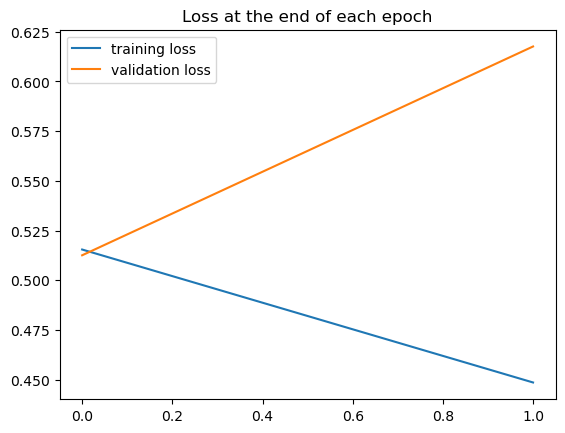

In [17]:
#plt.plot(train_losses, label='training loss')
plt.plot(train_losses_np, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [18]:
train_correct

[tensor(4978, device='cuda:0'), tensor(5672, device='cuda:0')]

In [19]:
# Si hemos usado GPU hay retornar a CPU para plotear
# Ejecutar SOLO si hemos usado GPU
train_correct = [ loss.cpu() for loss in train_correct]
test_correct = [ loss.cpu() for loss in test_correct]

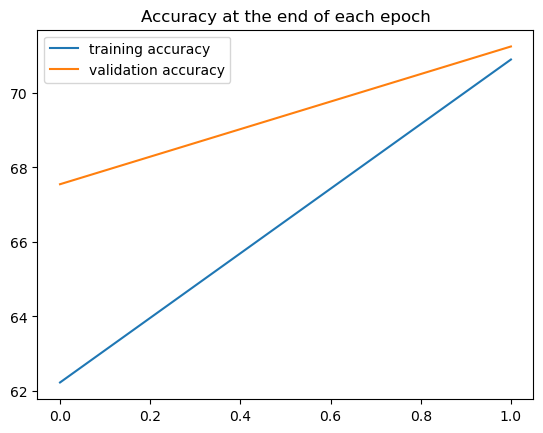

In [20]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/20 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [21]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/2000:.3f}%')

[tensor(1351), tensor(1425)]
Test accuracy: 71.250%


## Cargar un modelo salvado
Podemos cargar un modelo ya entrenado si no tenemos tiempo o recursos para entrenarlo. Se ha suministrado como 'CustomImageCNNModel-master.pt'.

Si tenemos guardado nuestro modelo lo llamaríamos 'CustomImageCNNModel.pt'.

In [22]:
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CustomImageCNNModel-master.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [23]:
# Evaluación del modelo cargado
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

# Model to device
model2.to(device)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
      # Data to GPU
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      # Prediction
      y_val = model2(X_test)
      predicted = torch.max(y_val,1)[1]
      correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 1529/2000 =  76.450%


## Descarga de modelos preentrenados
Torchvision dispone de varios modelos preentrenados y de probada eficacia a través de <a href='https://pytorch.org/vision/stable/models.html#classification'>.<tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
Todos ellos han sido entrenados con la base de datos de imágenes <a href='http://www.image-net.org/'>ImageNet</a>. Nuestra única tarea es reducir la salida de las capas completamente conectadas de (típicamente) 1000 categorías a sólo 2.

Para acceder a los modelos, puedes construir un modelo con pesos aleatorios llamando a su constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
También puedes obtener un modelo preentrenado pasando pretrained=True: (obsoleto en nuevas próximas versiones)<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
<pre>resnet18 = models.resnet18(weights='DEFAULT') # Próximamente</pre>

Todos los modelos preentrenados esperan imágenes de entrada normalizadas del mismo modo, es decir, minilotes de imágenes RGB de 3 canales de forma (3 x H x W), donde se espera que H y W sean al menos 224. Las imágenes deben cargarse en un intervalo de [0, 1] y luego normalizarse utilizando media = [0,485, 0,456, 0,406] y std = [0,229, 0,224, 0,225].

Siéntete libre de investigar los distintos modelos disponibles. Cada uno de ellos se descargará en un directorio caché la primera vez que se acceda a ellos; a partir de ese momento, estarán disponibles localmente.

Por su sencillez y eficacia, utilizaremos AlexNet:

In [24]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<div class="alert alert-info">Este modelo emplea <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a>para convertir la gran matriz que sale de las capas convolucionales en una matriz (6x6)x256 que se introduce en las capas totalmente conectadas.</div>

## Congelar parámetros
Queremos congelar los pesos y sesgos pre-entrenados. Establecemos <tt>.requires_grad</tt> a False así no se produce backprop a través de ellos.

In [25]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

## Modificar el clasificador
A continuación tenemos que modificar las capas totalmente conectadas para producir una salida binaria. La sección está etiquetada como "clasificador" en el modelo AlexNet.<br>
Ten en cuenta que cuando asignamos nuevas capas, sus parámetros por defecto son <tt>.requires_grad=True</tt>.

In [26]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(
                                nn.Linear(9216, 1024),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(1024, 2),
                                nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [27]:
# Parámetros entrenables:
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


## Definir la función de pérdida y el optimizador
Sólo queremos optimizar los parámetros del clasificador, ya que los parámetros de las características están congelados.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

## Entrenar el modelo
Recuerda que sólo estamos entrenando las capas totalmente conectadas. Las capas convolucionales tienen pesos y sesgos fijos. Por esta razón, sólo tenemos que ejecutar una época (que recorrerá todos los lotes).

In [29]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.04579475  accuracy:  88.750%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.65772378  accuracy:  91.150%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.02581919  accuracy:  91.750%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.25675365  accuracy:  92.237%

Duration: 194 seconds


In [30]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/2000:.3f}%')

[tensor(1895)]
Test accuracy: 94.750%


¿Hay diferencia con los resultados obtenidos? ¿El preentrenamiento funciona?

## Pasar una nueva imagen por el modelo
También podemos pasar una sola imagen por el modelo para obtener una predicción.<br>
Elija un número de 0 a 2000, asígnalo a "x" y utilizaremos ese valor para seleccionar una imagen del conjunto de pruebas Cats and Dogs.

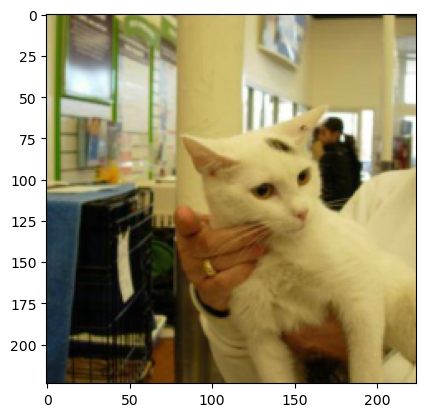

In [31]:
x = 111
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [32]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [33]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


## Conclusiones finales
¿Que conclusiones sacas del uso de diferentes modelos? <br>
¿Que ventajas y/o inconvenientes tiene entrenar desde cero? <br>
¿Que ventajas y/o inconvenientes tiene usar modelos preentrenados? <br>

## Buen trabajo!